In [8]:
from sklearn.model_selection import GroupKFold
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

import scipy.io as sio
import neurokit2 as nk

import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path_DREAMER = "../Datasets/DREAMER.mat"
raw = sio.loadmat(path_DREAMER)

In [84]:
plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['font.size']= 13

In [89]:
ecg = nk.ecg_simulate(sampling_rate=256, heart_rate=80)
nk.signal_plot(ecg)

In [90]:
# Define a new function
def my_processing(ecg_signal):
    # Do processing
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=256, method="engzeemod2012")
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=256)
    rate = nk.ecg_rate(rpeaks, sampling_rate=256, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=256)

    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality})
    signals = pd.concat([signals, instant_peaks], axis=1)
    info = rpeaks

    return signals, info

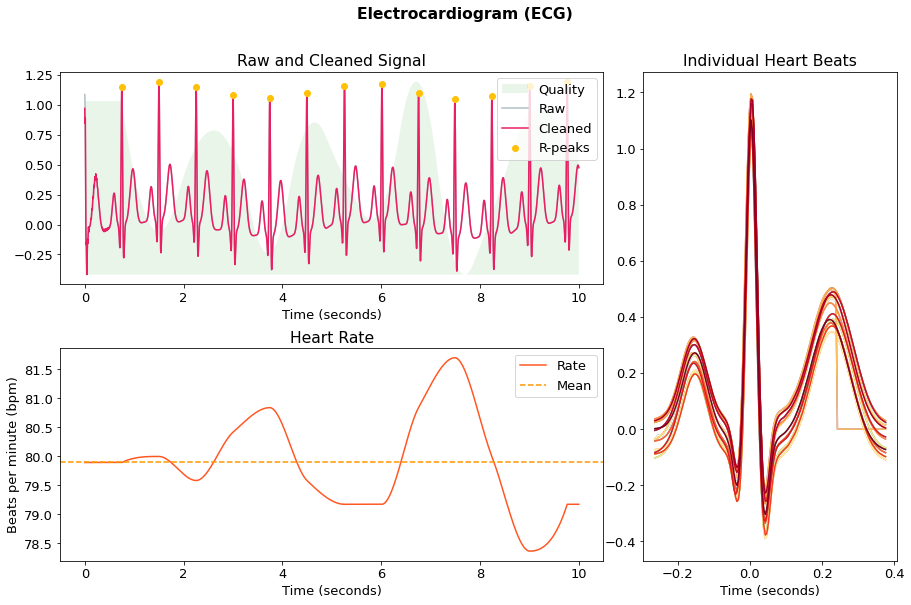

In [97]:
signal,info = my_processing(ecg)
plot = nk.ecg_plot(signal[:3000], sampling_rate=256)

In [96]:
data = nk.ecg_intervalrelated(signal)
data = pd.DataFrame(data , columns = [
                                        'ECG_Rate_Mean','HRV_MeanNN','HRV_SDNN'
                                        ,'HRV_RMSSD','HRV_SDSD','HRV_CVNN','HRV_CVSD','HRV_MedianNN','HRV_MadNN'
                                        ,'HRV_MCVNN','HRV_IQRNN','HRV_HTI','HRV_HF','HRV_HFn','HRV_LnHF','HRV_SD1','HRV_SD2'
                                        ,'HRV_SD1SD2','HRV_S','HRV_CSI','HRV_CVI','HRV_CSI_Modified','HRV_PIP','HRV_IALS'
                                        ,'HRV_PSS','HRV_GI','HRV_SI','HRV_AI','HRV_PI','HRV_C1d','HRV_C1a','HRV_SD1d'
                                        ,'HRV_SD1a','HRV_C2d','HRV_C2a','HRV_SD2d','HRV_SD2a','HRV_Cd','HRV_Ca','HRV_SDNNd'
                                        ,'HRV_SDNNa','HRV_DFA_alpha1','HRV_DFA_alpha1_ExpRange','HRV_DFA_alpha1_ExpMean'
                                        ,'HRV_DFA_alpha1_DimRange','HRV_DFA_alpha1_DimMean','HRV_ApEn','HRV_SampEn'
                                    ])

data.to_csv("Data/HeartManual/manual.csv")

C:\Users\User\anaconda3\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `windows` argument in `nk.fractal_dfa()` for more information.
  warn(
C:\Users\User\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:202: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
C:\Users\User\anaconda3\lib\site-packages\neurokit2\complexity\optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 6 (the max).
  warn(


In [3]:
def feat_extract_ECG(raw):
    data_ECG = {}
    for participant in range(0, 23):
        for video in range(0, 18):
        
            basl_left = (raw["DREAMER"][0, 0]["Data"]
                         [0, participant]["ECG"][0, 0]
                         ["baseline"][0, 0][video, 0][:, 0])
            stim_left = (raw["DREAMER"][0, 0]["Data"]
                         [0, participant]["ECG"][0, 0]
                         ["stimuli"][0, 0][video, 0][:, 0])
            basl_right = (raw["DREAMER"][0, 0]["Data"]
                          [0, participant]["ECG"][0, 0]
                          ["baseline"][0, 0][video, 0][:, 1])
            stim_right = (raw["DREAMER"][0, 0]["Data"]
                          [0, participant]["ECG"][0, 0]
                          ["stimuli"][0, 0][video, 0][:, 1])
            
            # signals_b_l, info_b_l = nk.ecg_process(basl_left,sampling_rate=256)
            signals_s_l, info_s_l = nk.ecg_process(stim_left,sampling_rate=256)
            # signals_b_r, info_b_r = nk.ecg_process(basl_right,sampling_rate=256)
            signals_s_r, info_s_r = nk.ecg_process(stim_right,sampling_rate=256)
            
            features_ecg_l = nk.ecg_intervalrelated(signals_s_l)
            features_ecg_r = nk.ecg_intervalrelated(signals_s_r)
            
            features_ecg = (features_ecg_l + features_ecg_r)/2
            if not len(data_ECG):
                data_ECG = features_ecg
            else:
                data_ECG = pd.concat([data_ECG, features_ecg],
                                     ignore_index=True)
    return data_ECG

In [4]:
def participant_affective(raw):
    a = np.zeros((23, 18, 9), dtype=object)
    for participant in range(0, 23):
        for video in range(0, 18):
            a[participant, video, 0] = (raw["DREAMER"][0, 0]["Data"]
                                        [0, participant]["Age"][0][0][0])
            a[participant, video, 1] = (raw["DREAMER"][0, 0]["Data"]
                                        [0, participant]["Gender"][0][0][0])
            a[participant, video, 2] = int(participant+1)
            a[participant, video, 3] = int(video+1)
            a[participant, video, 4] = ["Searching for Bobby Fischer",
                                        "D.O.A.", "The Hangover", "The Ring",
                                        "300", "National Lampoon\'s VanWilder",
                                        "Wall-E", "Crash", "My Girl",
                                        "The Fly", "Pride and Prejudice",
                                        "Modern Times", "Remember the Titans",
                                        "Gentlemans Agreement", "Psycho",
                                        "The Bourne Identitiy",
                                        "The Shawshank Redemption",
                                        "The Departed"][video]
            a[participant, video, 5] = ["calmness", "surprise", "amusement",
                                        "fear", "excitement", "disgust",
                                        "happiness", "anger", "sadness",
                                        "disgust", "calmness", "amusement",
                                        "happiness", "anger", "fear",
                                        "excitement", "sadness",
                                        "surprise"][video]
            a[participant, video, 6] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreValence"]
                                           [0, 0][video, 0])
            a[participant, video, 7] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreArousal"]
                                           [0, 0][video, 0])
            a[participant, video, 8] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreDominance"]
                                           [0, 0][video, 0])
    b = pd.DataFrame(a.reshape((23*18, a.shape[2])),
                     columns=["age", "gender", "participant",
                              "video", "video_name", "target_emotion",
                              "valence", "arousal", "dominance"])
    return b

In [5]:
df_ECG = feat_extract_ECG(raw)
df_features = pd.concat([df_ECG], axis=1)
df_participant_affective = participant_affective(raw)

df_participant_affective["valence"] = (df_participant_affective
                                       ["valence"].astype(int))
df_participant_affective["arousal"] = (df_participant_affective
                                       ["arousal"].astype(int))
df_participant_affective["dominance"] = (df_participant_affective
                                         ["dominance"].astype(int))
df = pd.concat([df_features, df_participant_affective], axis=1)

In [8]:
data = df.loc[(df['target_emotion'] == 'calmness') |
              (df['target_emotion'] == 'happiness') |
              (df['target_emotion'] == 'sadness')|
              (df['target_emotion'] == 'anger')|
              (df['target_emotion'] == 'fear')|
              (df['target_emotion'] == 'surprise')
              ].copy()

In [9]:
data['stress_bin'] = data['target_emotion'].map(
    {'calmness': 0, 'happiness': 1, 'sadness': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
)

In [10]:
data = pd.DataFrame(data , columns = [
                                        'ECG_Rate_Mean','HRV_MeanNN','HRV_SDNN'
                                        ,'HRV_RMSSD','HRV_SDSD','HRV_CVNN','HRV_CVSD','HRV_MedianNN','HRV_MadNN'
                                        ,'HRV_MCVNN','HRV_IQRNN','HRV_HTI','HRV_HF','HRV_HFn','HRV_LnHF','HRV_SD1','HRV_SD2'
                                        ,'HRV_SD1SD2','HRV_S','HRV_CSI','HRV_CVI','HRV_CSI_Modified','HRV_PIP','HRV_IALS'
                                        ,'HRV_PSS','HRV_GI','HRV_SI','HRV_AI','HRV_PI','HRV_C1d','HRV_C1a','HRV_SD1d'
                                        ,'HRV_SD1a','HRV_C2d','HRV_C2a','HRV_SD2d','HRV_SD2a','HRV_Cd','HRV_Ca','HRV_SDNNd'
                                        ,'HRV_SDNNa','HRV_DFA_alpha1','HRV_DFA_alpha1_ExpRange','HRV_DFA_alpha1_ExpMean'
                                        ,'HRV_DFA_alpha1_DimRange','HRV_DFA_alpha1_DimMean','HRV_ApEn','HRV_SampEn'
                                        ,'gender','age','target_emotion','valence','arousal','dominance','stress_bin','participant'
                                    ])

In [9]:
data.to_csv('Data/dataML_Modified.csv')

In [10]:
group_kfold = GroupKFold(n_splits=10)
X = np.array(data.loc[:, 'ECG_Rate_Mean':'HRV_SampEn'])
y = np.array(data['stress_bin'])
groups = np.array(data['participant'])
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [11]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(252, 48) (252,) (24, 48) (24,)


In [12]:
def run_clf(clf):
    cv = GroupKFold(n_splits=10)
    score = []
    runtime = []
    for fold, (train, test) in enumerate(cv.split(X, y, groups)):
        clf.fit(X[train], y[train])
        start = time.time()
        score.append(clf.score(X_test, y_test))
        runtime.append(time.time() - start)

    return score, runtime

In [13]:
results = []
model = make_pipeline(MinMaxScaler(), SVC(gamma=2, C=1))
score, runtime = run_clf(model)
results.append(["SVC", round(np.mean(score)*100,1), round(np.mean(runtime),9)])

In [14]:
results_df = pd.DataFrame(results, columns=['Name', 'Score', 'Runtime'])
print(results_df)

  Name  Score   Runtime
0  SVC   87.1  0.001282


In [15]:
emotionData = pd.read_csv("Data/HeartEmotions/happy.csv")
tester = np.array(emotionData.loc[:, 'ECG_Rate_Mean':'HRV_SampEn'])

In [16]:
#### 'calmness': 0, 'happiness': 1, 'sadness': 2, 'anger': 3, 'fear': 4, 'surprise': 5 ####
tester = tester.reshape(1,-1)
emotion = model.predict(tester)
print(emotion)

[1]
